In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [2]:
def even_block():
    #set of 4 initial Rz gates and then a combination of Cz gates (two-qubit gate)
    pass

def odd_block(): 
    
    #set of 4 Rx gates applied to each qubit
    pass
    
def layer_block():
    
    #an even block + odd block -> one layer
    pass

In [3]:
#qiskit even block

qc_even = QuantumCircuit(4)

for i in range(4):
    qc_even.rz(np.pi/2,i) #this must be a parametrized circuit 4 four different angles, e.g theta[i]
    
tuples = [(i,j) for i in range(4) for j in range(4) if i < j]

for tup in tuples:
    qc_even.cz(tup[0], tup[1])


qc_even.draw()

def even_block(qc):
    
    for i in range(4):
        qc.rz(np.pi/2,i) #this must be a parametrized circuit 4 four different angles, e.g theta[i]
    
    tuples = [(i,j) for i in range(4) for j in range(4) if i < j]

    for tup in tuples:
        qc.cz(tup[0], tup[1])

In [4]:
#qiskit  odd block

qc_odd = QuantumCircuit(4)

for i in range(4):
    qc_odd.rx(np.pi/2, i)
qc_odd.draw()

def odd_block(qc):
    
    for i in range(4):
        qc.rx(np.pi/2, i)

In [5]:
def layer(qc):
    
    odd_block(qc)
    even_block(qc)
    qc.barrier()

In [6]:
def built_circuit(qc, layers):
    
    for i in range(layers):
        layer(qc)

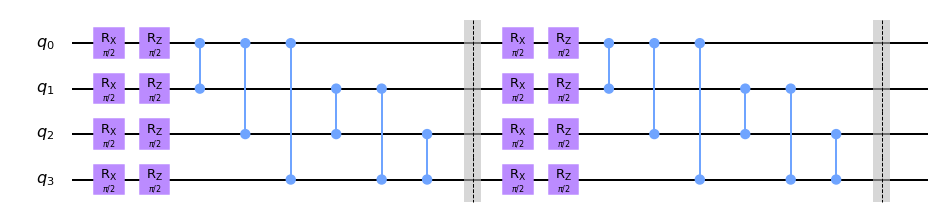

In [7]:
qc = QuantumCircuit(4)

built_circuit(qc, 2)

qc.draw(output='mpl')